# TRY TO UNDERSTAND WHERE TO PUT PREPROCESS BASED ON WHO IS CALLING IT
the neural network needs it in order to feed itself  
the agent needs it because it calls the neural network  
so i guess the neural network needs it

# Imports

In [275]:
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.agents.agent import Agent, RandomAgent, FixedPlanAgent
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from typing import Tuple, List, Dict

# Useful classes 

Policy class: NN for computing the probability distribution of the actions to take.

In [295]:
class Policy(Model):
    def __init__(self, input_shape, num_actions, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(128, activation='relu')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    
    def process_gradient(self, gradient, delta):
        processed_gradient = []
        for grad in gradient:
            if tf.rank(grad) == 2 and grad.shape[0] == 1:
                processed_gradient.append(-delta*tf.squeeze(grad))
            else:
                processed_gradient.append(grad)
        return gradient
        

    def call(self, obs, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b)

    def build_model(self):
        # you can find a sketch on Understanding overcooked.ipynb
        pass    
    
    def train_step(self, delta, obs: Tuple, action: Tuple[int,int]):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs, training=True)
            # HERE need to compute the log probabilities
            log_pi = tf.math.log(pi)
            pi_a = log_pi[0][..., action[0]] + log_pi[1][..., action[1]] # computing the sum of the probability of the best actions
        
        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        processed_gradient = self.process_gradient(grad_pi_a, delta)
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))

ValueFunctionApproximator class: NN for approximating the value function of a given state.

In [296]:
class ValueFunctionApproximator(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(128, activation='relu')
        self.value_function = layers.Dense(1, activation='relu', name="value_function")
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    
    def process_gradient(self, gradient, delta):
        processed_gradient = []
        for grad in gradient:
            if tf.rank(grad) == 2 and grad.shape[0] == 1:
                processed_gradient.append(-delta*tf.squeeze(grad))
            else:
                processed_gradient.append(grad)
        return gradient

    def call(self, obs: Tuple, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self):
        # you can find a sketch on Understanding overcooked.ipynb
        pass   
    
    def train_step(self, delta, obs: Tuple):
        # update w with w + alpha_w*delta*grad_v^(St)
        with tf.GradientTape() as tape:
            state_value = self.call(obs, training=True)
        
        grad_state_value = tape.gradient(state_value, self.trainable_weights)
        processed_gradient = self.process_gradient(grad_state_value, delta)
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))


Agent class: inherits from Agent class found in agent.py

In [ ]:
class MyAgent(Agent):
    """
    This class is more a couple of actors since we use shared networks and the output are 2!!!
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, critic, idx):
        super().__init__()
        self.actor = actor
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")

    def action(self, obs):
        """
        obs: preprocessed observation
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        action_probs = self.actor.call(obs)[self.idx].numpy()
        if np.random.random() < 0.1:
            action = Action.argmax(action_probs)
        else:
            action = Action.INDEX_TO_ACTION[np.random.choice(range(0,6), size=1)[0]]
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

Let's define a useful function for preprocessing the observation in order to feed our neural networks

In [298]:
# def preprocess(obs):
#     agent_1_obs = obs['both_agent_obs'][0]
#     agent_2_obs = obs['both_agent_obs'][1]
#     return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))

# Let's start coding!

Let's define our environment:

In [299]:
number_of_frames = 1000
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

Let's instantiate our networks and the hyperparameters:

In [300]:
number_of_episodes = 1000
alpha_w = 1e-3
alpha_t = 1e-3
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [301]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

Let's instantiate our agents:

In [302]:
agent_1 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx = 0
)
agent_2 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx = 1
)

Let's define our training loop! Let's go for now for a bootstrapping method.

Episode terminated at timestep 0


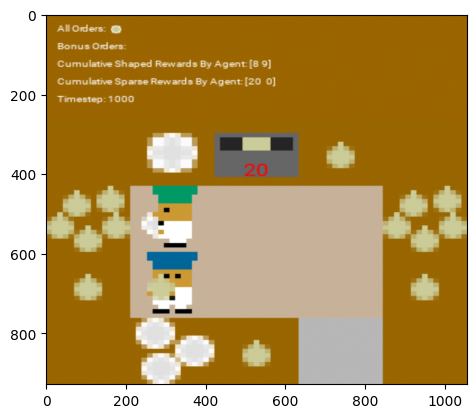

Episode terminated at timestep 1


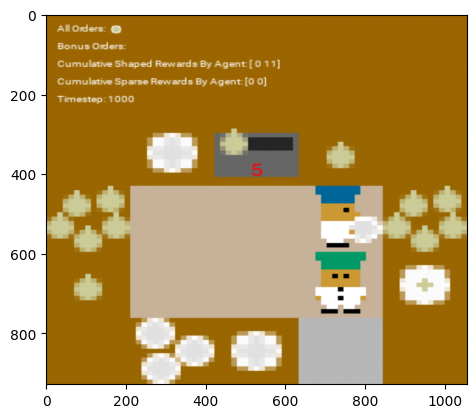

Episode terminated at timestep 2


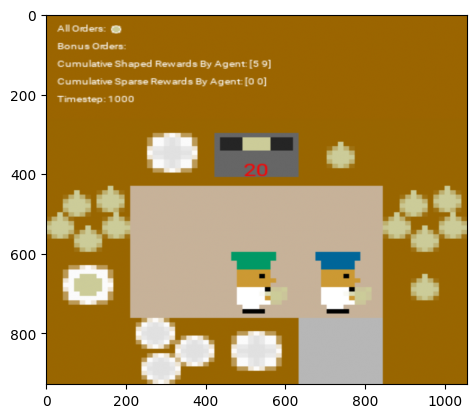

KeyboardInterrupt: 

In [303]:
for episode in range(number_of_episodes):
    obs = env.reset()
    done = False
    while not done:
        # compute v^(St), actually is already obs!
        action1 = agent_1.action(obs)
        action2 = agent_2.action(obs)
        player_1_action = Action.ACTION_TO_INDEX[action1[0]]
        player_2_action = Action.ACTION_TO_INDEX[action2[0]]
        action = (player_1_action, player_2_action)

        new_obs, reward, done, env_info = env.step(action)
        shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.
        total_reward = reward + shaped_reward
        # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
        if done:
            delta = reward - shared_critic.call(obs)
        else:
            delta = reward + shared_critic.call(new_obs) - shared_critic.call(obs)
        # update w with w + alpha_w*delta*grad_v^(St)
        shared_critic.train_step(delta, obs)        
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        shared_actor.train_step(delta, obs, action)
        # update state (obs = new_obs) 
        obs = new_obs  



        
    print(f"Episode terminated at timestep {episode}")

    render = env.render() / 255.0
    plt.imshow(render)
    plt.show()

In [268]:
delta = reward + shared_critic.call(new_obs) - shared_critic.call(obs)
with tf.GradientTape() as tape:
    state_value = shared_critic.call(obs, training=True)

grad_state_value = tape.gradient(state_value, shared_critic.trainable_weights)
processed_gradient = [-delta*tf.squeeze(grad) if tf.rank(grad) == 2 and grad.shape[0] == 1 else -delta * grad for grad in grad_state_value]
shared_critic.optimizer.apply_gradients(zip(processed_gradient, shared_critic.trainable_weights))

InvalidArgumentError: {{function_node __wrapped__AssignAddVariableOp_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot update variable with shape [128] using a Tensor with shape [1,128], shapes must be equal. [Op:AssignAddVariableOp] name: 

In [ ]:
processed_gradient = []
for grad in grad_state_value:
    if tf.rank(grad) == 2 and grad.shape[0] == 1:
        processed_gradient.append(-delta*tf.squeeze(grad))
    else:
        processed_gradient.append(grad)
# processed_gradient = [-delta*tf.squeeze(grad) if tf.rank(grad) == 2 and grad.shape[0] == 1 else -delta * grad for grad in grad_state_value]

In [274]:
for i in range(0,6):
    print(f"{[i]} shape gradient: {processed_gradient[i].shape}")
    print(f"{[i]} rank gradient: {tf.rank(processed_gradient[i])}")
    print(f"{[i]} shape weights: {shared_critic.trainable_weights[i].shape}")
    print(f"{[i]} rank weights: {tf.rank(shared_critic.trainable_weights[i])}")

[0] shape gradient: (192, 128)
[0] rank gradient: 2
[0] shape weights: (192, 128)
[0] rank weights: 2
[1] shape gradient: (128,)
[1] rank gradient: 1
[1] shape weights: (128,)
[1] rank weights: 1
[2] shape gradient: (128, 128)
[2] rank gradient: 2
[2] shape weights: (128, 128)
[2] rank weights: 2
[3] shape gradient: (128,)
[3] rank gradient: 1
[3] shape weights: (128,)
[3] rank weights: 1
[4] shape gradient: (128, 1)
[4] rank gradient: 2
[4] shape weights: (128, 1)
[4] rank weights: 2
[5] shape gradient: (1,)
[5] rank gradient: 1
[5] shape weights: (1,)
[5] rank weights: 1


In [266]:
processed_gradient[3].shape[0] == 1

True

In [221]:
state_value = shared_critic.call(obs, training=True)
print(state_value)

tf.Tensor([[0.82398677]], shape=(1, 1), dtype=float32)


In [234]:
len(shared_critic.trainable_variables)

6

In [235]:
delta

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.3555324]], dtype=float32)>